# Atividade 7 - Arquitetura de Computadores - PPGI

Aluno: Victor José de Sousa Koehler

Matrícula: 20211023501


## Introdução

Neste trabalho é apresentado um breve estudo sobre o comportamento dos preditores de *branches* nos processadores modernos. Mais especificamente, foi implementado um simples programa baseado nos materiais da disciplina do professor Alisson Brito (https://drive.google.com/drive/folders/1jaVBTxe3zpIZb2BnYBNtflO2yecq2bwP) que possui como objetivo medir o custo de tempo associado com a execução de um bloco de decisão `if-else`, especialmente para o caso `else`.

Os códigos de interesse foram implementados na linguagem Rust, compilados utilizando Cargo/rustc versão 1.61.0 (a028ae4 2022-04-29/fe5b13d68 2022-05-18) e testados em um computador executando o sistema operacional Ubuntu 20.04.1, kernel Linux versão 5.13.0-44-generic#49, equipado com 8GB de RAM e processador AMD Ryzen 7 5700U cujas capacidades de cache L1 de instruções e dados, L2 e L3 são, respectivamente, 256 KiB, 256 KiB, 4 MiB e 8 MiB, como ilustrado na seguinte imagem:

![Detalhes da CPU](lscpu.png "Detalhes da CPU")



## Estrutura do Código

A pasta `src/` abriga o único arquivo de código-fonte: main.rs. Nele, encontra-se uma declaração de `struct`, *Triplet*, que contém três números de ponto flutuante, bem como 6 definições de funções:

```Rust
struct Triplet {
    a : f64,
    b : f64,
    c : f64
}

fn populate(buff : &mut Vec<Triplet>, n : usize, true_percentage : usize) -> i32 // Cria e adiciona `n` elementos em buff, das quais `true_proportion`  deles satisfazem a condição t.a > t.b, e os demais t.a <= b; todos satisfazem t.c = 0.
fn operate_sum(buff : &mut Vec<Triplet>, a : f64, b : f64, c : f64) // Para cada elemento t em buff, faz t.a += a; t.b += b; t.c += c
fn operate_multiply(buff : &mut Vec<Triplet>, a : f64, b : f64, c : f64) // Para cada elemento t em buff, faz t.a *= a; t.b *= b; t.c *= c
fn operate_print(buff : &Vec<Triplet>) // Imprime os valores de buff
fn the_benchmark(buff : &mut Vec<Triplet>, repeat_ : i32) -> u128 // Realiza o benchmark
fn main() // Lê comandos do terminal padrão.
```

A função `main()`, invocada na inicialização do programa, lê comandos e parâmetros da entrada padrão e invoca as funções correspondentes mencionadas acima (com exceção da própria `main`) em qualquer ordem especificada pelo usuário, operando sobre o vetor `buff` declarada nela própria. O bloco de código abaixo resume a implementação da função `main`. Por sua vez, `populate` inicializa/incrementa o vetor `buff` com `n` *Triplets* com números reais aleatórios no intervalo 0 a 1, das quais `true_proportion` deles satisfazem a condição `t.a > t.b`, e os demais `t.a <= b`; todos satisfazem `t.c = 0`.

```Rust
fn main() {
    let mut buff: Vec<Triplet> = Vec::new();

    loop { // ... significa omitido
        cmds = ...; // Lê uma linha (comando) da entrada padrão e quebra em partes

        match cmds[0] { // A primeira parte contém o comando, o restante são os parâmetros
            "pop" => { ... populate(&mut buff, n, t); ... },
            "sum" => { ... operate_sum(&mut buff, v[0], v[1], v[2]); },
            "multiply" => { ... operate_multiply(&mut buff, v[0], v[1], v[2]); },
            "print" => { operate_print(&buff); },
            "bench" => { ... the_benchmark(&mut buff, cmds[1]) ... },
            _ => { panic!("Invalid operation: '{}'", cmds[0]); }
        }
    }
}
```


A função `the_benchmark` realiza e cronometra os experimentos. A **Linha (I)** contém o `if` sendo estudado, e a **Linha (II)** o `else` correspondente: Cada bloco desses dois condicionais são idênticos com exceção dos coeficientes e da ordem de algumas instruções utilizadas, e a proporção que eles são acessados dependem da função `populate` (mais especificamente, do argumento `true_proportion`). As demais funções, `operate_sum`, `operate_multiply`, `operate_print`, estão presentes com o principal intuito de garantir que o compilador não aplique otimizações agressivas a partir da inferência do comportamento dos dados, não tendo sido utilizadas no decorrer dos experimentos realizados neste relatório. Assim sendo, os 6 blocos `if` destacados com "*geralmente verdade*" na função `the_benchmark` abaixo estão presentes no *assembly* final e são garantidamente executados em todas as iterações pois, como dito anteriormente, `populate` gera números entre 0 e 1.

```Rust
fn the_benchmark(buff : &mut Vec<Triplet>, repeat_ : i32) -> u128 {
    let start = Instant::now();
    for _ in 0..repeat_ {
        for t in &mut *buff {
            for _ in 0..5 {
                if t.a > t.b { // Linha (I): if sendo avaliado
                    let mut p1 = t.a*5.0 - t.b*4.0 + t.a*t.c*2.0;
                    if t.a >= 0.0 { p1 += 2.0; } // geralmente verdade
                    if t.b >= 0.0 { p1 *= 1.5; } // geralmente verdade
                    if t.b*t.a >= 0.0 { p1 += 0.5; } // geralmente verdade
                    t.c += p1;
                } else { // Linha (II): else sendo avaliado
                    let mut p1 = t.a*6.0 - t.b*5.1 + t.a*t.c*1.8;
                    if t.b >= 0.0 { p1 *= 1.1; } // geralmente verdade
                    if t.a >= 0.0 { p1 += 2.1; } // geralmente verdade
                    if t.b*t.a >= 0.0 { p1 += 0.6; } // geralmente verdade
                    t.c += p1;
                }
            }
        }
    }
    return start.elapsed().as_nanos();
}
```

## Experimentos

In [2]:
import os
import itertools
import pandas as pd
import seaborn as sns

In [3]:
def read_file(fn):
    with open(fn, 'r') as fh:
        return fh.read()

def read_bench_file(fn : str):
    c = fn.split('/')[-1].rsplit('.', 1)[0].split('_') # sz, rep, dist, prof
    c.append(c[0] + ' & ' + c[-1])
    c[0], c[1], c[2] = float(c[0]), float(c[1]), float(c[2])
    return [c+[float(i.rsplit(' ', 1)[1].strip())] for i in read_file(fn).split('\n') if 'Benchmark results' in i]

_pref = '../output/'
_cols = ['size', 'repeat', 'true_percentage', 'profile', 'size&profile', 'time']
df = pd.DataFrame(itertools.chain(*[read_bench_file(_pref+i) for i in os.listdir(_pref)]), columns=_cols).sort_values(_cols)
df_sz1e6 = df[df['size'] == 1e6]
df_sz1e8 = df[df['size'] == 1e8]
# df_sz1e8

Os experimentos foram realizados utilizando os dois perfis padrões de otmização da linguagem Rust: *debug*, padrão, sem otimizações, destinado a facilitar o desenvolvimento, e *release*, destinado a produzir binários otimizados para produção. Além disso, foram selecionados os seguintes valores para os parâmetros: `size` = {$10^6, 10^8$}, que representa o parâmetro `n` da função `populate`; `true_percentage` = {$5\%, 95\%$} que representa a proporção de `size` que entrará no `if` da **Linha (I)** (segundo parâmetro da função `populate`); e, por fim, `repeat` = $10^3$ caso `size` = $10^8$ ou `repeat` = $10^4$ caso `size` = $10^6$, que representa o parâmetro `repeat_` de `the_benchmark` e serve para repetir em laço o experimento, aumentando a escala de tempo [do experimento] sem o aumento de memória que seria necessário com o acréscimo de `size`.

Para todas as combinações de parâmetros, com exceção de `size` = $10^8$ e *debug* devido ao alto custo de tempo necessário, foram realizadas 5 execuções de forma alternada entre os parâmetros para mitigar potenciais ganhos causados por *boosts* ou perdas em decorrência de sobreaquecimento do computador. A Tabela a seguir relaciona os resultados da média do tempo das execuções em segundos.

In [4]:
df.pivot_table(values='time', index=['size', 'repeat', 'profile'], columns=['true_percentage'], aggfunc='mean')

true_percentage                    5.0         95.0
size        repeat  profile                        
1000000.0   10000.0 debug    139.517234  142.653327
                    release   11.756434   11.702592
100000000.0 1000.0  release  117.544678  116.956444

A Tabela a seguir relaciona os mesmos experimentos, porém em função do valor mínimo, máximo e o desvio padrão obtido entre os 5 experimentos.

In [8]:
df.pivot_table(values='time', index=['size', 'repeat', 'profile'], columns=['true_percentage'], aggfunc=['min', 'max', 'std'])

min                     max              \
true_percentage                    5.0         95.0        5.0         95.0   
size        repeat  profile                                                   
1000000.0   10000.0 debug    139.279009  142.119574  140.169759  143.549068   
                    release   11.743516   11.684414   11.775050   11.746374   
100000000.0 1000.0  release  117.391698  116.729464  117.776748  117.362745   

                                  std            
true_percentage                  5.0       95.0  
size        repeat  profile                      
1000000.0   10000.0 debug    0.373347  0.570717  
                    release  0.011724  0.025139  
100000000.0 1000.0  release  0.152865  0.239805

Por fim, o diagrama de caixa a seguir ilustra os resultados das Tabelas anteriores e sugere que, pelo menos no computador, compilador e programa analisado, o bloco da **Linha (I)** (if) é priorizado em detrimento da **Linha (II)** (else) no caso de perfis de compilação em modo *release*, e o inverso ocorre no modo *debug* (razões não exploradas).

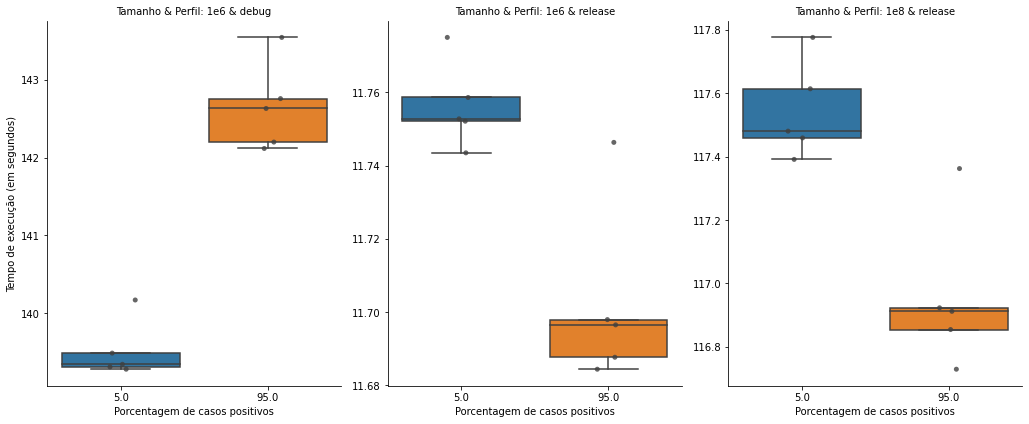

In [6]:
_x = 'true_percentage'
g = sns.catplot(x=_x, y='time', col='size&profile', fliersize=0,
                data=df, kind="box", height=6, aspect=.8, sharey=False)
g.map_dataframe(sns.stripplot, x=_x, y='time',
                palette=["#404040"], alpha=0.8, dodge=True)
_ = g.set_axis_labels("Porcentagem de casos positivos", "Tempo de execução (em segundos)").set_titles("Tamanho & Perfil: {col_name}")

Apesar da diferença de tempo não ser muito significativa, tal fenômeno pode ser explicado analisando-se o *assembly* dos binários gerados, localizados nos arquivos `report/release.s` e `report/debug.s` cujos nomes são respectivos aos perfis de compilação utilizados. Em particular, observe a linha 1430 em diante de `report/release.s`:

```asm
// report/release.s::1430
.LBB49_138:
		// src/main.rs : 62
		if t.a > t.b {
	movupd xmm0, xmmword ptr [rax + rsi]
	movapd xmm1, xmm0
	unpckhpd xmm1, xmm0
	ucomisd xmm0, xmm1
	jbe .LBB49_154 // PULO CONDICIONAL PARA report/release.s::1630
.Ltmp2258:
	movsd xmm5, qword ptr [rax + rsi + 16]
.Ltmp2259:
		// src/main.rs : 63 // LINHA (I)
		let mut p1 = t.a*5.0 - t.b*4.0 + t.a*t.c*2.0;
	movapd xmm3, xmm0
	mulpd xmm3, xmmword ptr [rip + .LCPI49_6]
	movapd xmm2, xmm3
//
// ... OMITIDO
//
// report/release.s::1630
.LBB49_154:
		// src/main.rs : 69 // LINHA (II)
		let mut p1 = t.a*6.0 - t.b*5.1 + t.a*t.c*1.8;
	movapd xmm3, xmm0
	mulpd xmm3, xmmword ptr [rip + .LCPI49_1]
	movapd xmm2, xmm3

```

É possível observar que o bloco `if-else` é traduzido em um simples pulo condicional: Se a condição é verdadeira (t.a > t.b), a execução continua na **Linha (I)**; senão, o pulo é realizado para as instruções correspondentes a **Linha (II)**, o que pode ser uma operação custosa para o *pipeline* do processador.